In [6]:
import math
import torch
from torch import nn
from dltool import plot,dataprocess,attention


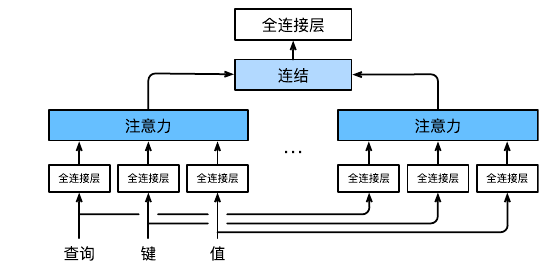
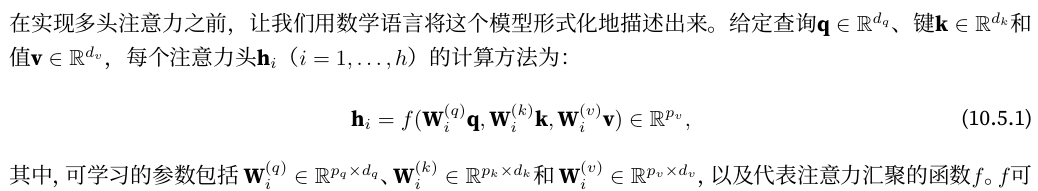

In [7]:
class DotProductAttention(nn.Module):
  """缩放点积注意力"""
  def __init__(self, dropout, **kwargs):
    super(DotProductAttention, self).__init__(**kwargs)
    self.dropout = nn.Dropout(dropout)
  
  # queries的形状:(batch_size,查询的个数,d),
  # keys的形状:(batch_size,键值对的个数,d),
  # values的形状:(batch_size,键值对的个数,值的维度)
  # valid_lens的形状:(batch_size,),或者(batch_size,查询的个数)
  def forward(self, queries, keys, values, valid_lens=None):
    d = queries.shape[-1]
    # 设置transpose_b=True为了交换keys的最后两个维度
    scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
    self.attention_weights = attention.masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

In [8]:
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [9]:
class MultiHeadAttention(nn.Module):
  """多头注意力"""
  def __init__(self, key_size, query_size, value_size, num_hiddens,
               num_heads, dropout, bias=False, **kwargs):
    super(MultiHeadAttention, self).__init__(**kwargs)
    self.num_heads = num_heads
    self.attention = attention.DotProductAttention(dropout)
    self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
    self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
    self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
    self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
  
  def forward(self, queries, keys, values, valid_lens):
    # queries，keys，values的形状:
    # (batch_size，查询或者“键－值”对的个数，num_hiddens)
    # valid_lens　的形状:
    # (batch_size，)或(batch_size，查询的个数)
    # 经过变换后，输出的queries，keys，values　的形状:
    # (batch_size*num_heads，查询或者“键－值”对的个数，
    # num_hiddens/num_heads)
    queries = transpose_qkv(self.W_q(queries), self.num_heads)
    keys = transpose_qkv(self.W_k(keys), self.num_heads)
    values = transpose_qkv(self.W_v(values), self.num_heads)

    if valid_lens is not None:
        # 在轴0，将第一项（标量或者矢量）复制num_heads次，
        # 然后如此复制第二项，然后诸如此类。
        valid_lens = torch.repeat_interleave(
            valid_lens, repeats=self.num_heads, dim=0)
    # output的形状:(batch_size*num_heads，查询的个数，
    # num_hiddens/num_heads)
    output = self.attention(queries, keys, values, valid_lens)
    # output_concat的形状:(batch_size，查询的个数，num_hiddens)
    output_concat = transpose_output(output, self.num_heads)
    return self.W_o(output_concat)
    

In [10]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [11]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])